In [14]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def compute_true_hessian(model, data, target, loss_fn):
    N = data.size(0)
    device = next(model.parameters()).device
    num_params = sum(p.numel() for p in model.fc3.parameters())
    hessian_matrix = torch.zeros(num_params, num_params).to(device)

    model.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    
    grads_tuple = torch.autograd.grad(loss, model.fc3.parameters(), create_graph=True)
    grad = torch.cat([g.view(-1) for g in grads_tuple])

    for j in range(num_params):
        grad_grad = torch.autograd.grad(grad[j], model.fc3.parameters(), retain_graph=True)
        hessian_matrix[j] += torch.cat([g.contiguous().view(-1) for g in grad_grad])
    
    hessian_matrix /= N
    return grad, hessian_matrix

def compute_bfgs_and_hessian(loss, model, data, target, loss_fn, B_k, prev_params, prev_grads):
    grads_tuple = torch.autograd.grad(loss, model.fc3.parameters(), create_graph=True, retain_graph=True)
    grads = torch.cat([g.view(-1) for g in grads_tuple])

    current_params = torch.cat([p.detach().view(-1) for p in model.fc3.parameters()])
    
    if prev_grads is not None:
        s_k = current_params - prev_params  
        y_k = grads.detach() - prev_grads    
        sy = y_k.dot(s_k)
        if sy > 1e-10:  
            sBks = s_k.dot(B_k @ s_k)
            B_k = B_k - torch.outer(B_k @ s_k, B_k @ s_k) / (sBks + 1e-10) + torch.outer(y_k, y_k) / (sy + 1e-10)
    
    new_prev_params = current_params.clone()
    new_prev_grads = grads.detach().clone()
    
    _, true_hessian = compute_true_hessian(model, data, target, loss_fn)
    
    return grads, B_k, new_prev_params, new_prev_grads, true_hessian

def full_loop_mlp(model, train_loader, test_loader, device, num_epochs=10, lr=1e-3, norm_order=2):
    train_losses, grad_norms, hess_norms_diff, accuracy_arr = [], [], [], []
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True)
    
    num_params = sum(p.numel() for p in model.fc3.parameters())
    B_k = torch.eye(num_params, device=device)  
    prev_grads = None
    prev_params = None
  
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for step, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            
            output = model(images)
            loss = loss_fn(output, labels)
            
            grads, B_k, prev_params, prev_grads, true_hessian = compute_bfgs_and_hessian(
                loss, model, images, labels, loss_fn, B_k, prev_params, prev_grads
            )
            
            train_losses.append(loss.item())
            grad_norms.append(torch.norm(grads, p=norm_order).item())
            hess_norms_diff.append(torch.norm(B_k - true_hessian, p=norm_order).item())
            
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch}, Loss: {train_losses[-1]}")

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        accuracy_arr.append(accuracy)
        print(f'Eval Accuracy: {accuracy:.2f}%')

    print("Finished Training")
    return train_losses, grad_norms, hess_norms_diff, accuracy_arr


def plot_relative_inexactness(
        grad_norms_array: str, 
        hess_norms_array: str, 
        title: str,
        M_constant: float = 1,
        plot_with_percentiles: bool = True,
        logscale: bool = False,
        do_smooth: bool = True,
    ):
    loaded_grad_norms_arr = np.load(grad_norms_array)
    loaded_hess_hutch_norm_diffs_arr = np.load(hess_norms_array)

    if do_smooth:
        loaded_grad_norms_arr = [smooth(l) for l in list(loaded_grad_norms_arr)]
        loaded_hess_hutch_norm_diffs_arr = [smooth(l) for l in list(loaded_hess_hutch_norm_diffs_arr)]
        
    relative_inexactness = M_constant * np.array(loaded_hess_hutch_norm_diffs_arr) / np.sqrt(loaded_grad_norms_arr)
    p50 = np.percentile(relative_inexactness, 50, axis=0)
    plt.figure(figsize=(16, 8), dpi=150)
    
    if plot_with_percentiles == False:
        if logscale:
            plt.loglog(p50, label=r'Relative Inexactness', color='r', linewidth=0.5)
        else:
            plt.plot(p50, label=r'Relative Inexactness', color='r', linewidth=0.5)
    else:
        p10 = np.percentile(relative_inexactness, 10, axis=0)
        p90 = np.percentile(relative_inexactness, 90, axis=0)
        if logscale:
            plt.loglog(p50, label=r'Relative Inexactness', color='r', linewidth=0.5)
        else:
            plt.plot(p50, label=r'Relative Inexactness', color='r', linewidth=0.5)
        plt.fill_between(range(len(loaded_grad_norms_arr[0])), p10, p90, color='r', alpha=0.2)

    plt.title(title, fontsize=40, fontweight='bold')
    plt.xlabel('Number of Iterations', fontsize=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='best', fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

def smooth(arr, window_size=10):
    """Apply a moving average smoothing to the array"""
    if len(arr) < window_size:
        return arr
    weights = np.ones(window_size) / window_size
    return np.convolve(arr, weights, mode='valid')

class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128, bias=False)
        self.fc2 = nn.Linear(128, 64, bias=False)
        self.fc3 = nn.Linear(64, 10, bias=False)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def plot_norms(
        grad_norms_array: str, 
        hess_norms_array: str, 
        title: str,
        M_constant: float = 1,
        plot_with_percentiles: bool = True,
        logscale: bool = False,
        do_smooth: bool =True,
    ):

    loaded_grad_norms_arr = np.load(grad_norms_array)
    loaded_hess_hutch_norm_diffs_arr = np.load(hess_norms_array)

    if do_smooth:
        loaded_grad_norms_arr = [smooth(l) for l in list(loaded_grad_norms_arr)]
        loaded_hess_hutch_norm_diffs_arr = [smooth(l) for l in list(loaded_hess_hutch_norm_diffs_arr)]

    plot_grad_norms_arr = np.sqrt(loaded_grad_norms_arr)
    plot_hess_hutch_norm_diffs_arr = M_constant * np.array(loaded_hess_hutch_norm_diffs_arr)

    gradp50 = np.percentile(plot_grad_norms_arr, 50, axis=0)
    hessp50 = np.percentile(plot_hess_hutch_norm_diffs_arr, 50, axis=0)

    plt.figure(figsize=(16, 8) ,dpi=150)

    if logscale:
        if plot_with_percentiles:
            gradp10 = np.percentile(plot_grad_norms_arr, 10, axis=0)
            gradp90 = np.percentile(plot_grad_norms_arr, 90, axis=0)
            hessp10 = np.percentile(plot_hess_hutch_norm_diffs_arr, 10, axis=0)
            hessp90 = np.percentile(plot_hess_hutch_norm_diffs_arr, 90, axis=0)

            plt.loglog(gradp50, label=r'$\|\nabla f\|^{1/2}$', color='b', linewidth=0.5)
            plt.fill_between(range(len(loaded_grad_norms_arr[0])), gradp10, gradp90, color='b', alpha=0.2)

            plt.loglog(hessp50, label=r'$\| H - \nabla^2 f\|$', color='g', linewidth=0.5)
            plt.fill_between(range(len(loaded_grad_norms_arr[0])), hessp10, hessp90, color='g', alpha=0.2)
        else:
            plt.loglog(gradp50, label=r'$\|\nabla f\|^{1/2}$', color='b', linewidth=0.5)
            plt.loglog(hessp50, label=r'$\| H - \nabla^2 f\|$', color='g', linewidth=0.5)
            
    else:
        if plot_with_percentiles:
            gradp10 = np.percentile(plot_grad_norms_arr, 10, axis=0)
            gradp90 = np.percentile(plot_grad_norms_arr, 90, axis=0)
            hessp10 = np.percentile(plot_hess_hutch_norm_diffs_arr, 10, axis=0)
            hessp90 = np.percentile(plot_hess_hutch_norm_diffs_arr, 90, axis=0)

            plt.plot(gradp50, label=r'$\|\nabla f\|^{1/2}$', color='b', linewidth=0.5)
            plt.fill_between(range(len(loaded_grad_norms_arr[0])), gradp10, gradp90, color='b', alpha=0.2)

            plt.plot(hessp50, label=r'$\| H - \nabla^2 f\|$', color='g', linewidth=0.5)
            plt.fill_between(range(len(loaded_grad_norms_arr[0])), hessp10, hessp90, color='g', alpha=0.2)
        else:
            plt.plot(gradp50, label=r'$\|\nabla f\|^{1/2}$', color='b', linewidth=0.5)
            plt.plot(hessp50, label=r'$\| H - \nabla^2 f\|$', color='g', linewidth=0.5)

    plt.title(title, fontsize=40, fontweight='bold')
    plt.xlabel('Number of Iterations', fontsize=45)
    plt.ylabel('Norm', fontsize=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='best', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.show()

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)  

Run 1/5


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Loss: 0.09116622805595398


 50%|█████     | 1/2 [04:19<04:19, 259.84s/it]

Eval Accuracy: 95.57%
Epoch 1, Loss: 0.5066593885421753


100%|██████████| 2/2 [08:02<00:00, 241.30s/it]


Eval Accuracy: 96.92%
Finished Training
Run 2/5


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Loss: 0.1372174620628357


 50%|█████     | 1/2 [03:45<03:45, 225.31s/it]

Eval Accuracy: 96.10%
Epoch 1, Loss: 0.049096960574388504


100%|██████████| 2/2 [07:28<00:00, 224.03s/it]


Eval Accuracy: 97.14%
Finished Training
Run 3/5


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Loss: 0.057032883167266846


 50%|█████     | 1/2 [03:42<03:42, 222.08s/it]

Eval Accuracy: 95.84%
Epoch 1, Loss: 0.053126197308301926


100%|██████████| 2/2 [07:42<00:00, 231.04s/it]


Eval Accuracy: 96.66%
Finished Training
Run 4/5


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Loss: 0.09626290947198868


 50%|█████     | 1/2 [04:06<04:06, 246.08s/it]

Eval Accuracy: 95.84%
Epoch 1, Loss: 0.0992690920829773


100%|██████████| 2/2 [07:54<00:00, 237.44s/it]


Eval Accuracy: 96.98%
Finished Training
Run 5/5


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Loss: 0.467706561088562


 50%|█████     | 1/2 [03:45<03:45, 225.38s/it]

Eval Accuracy: 95.95%
Epoch 1, Loss: 0.037616223096847534


100%|██████████| 2/2 [07:28<00:00, 224.14s/it]

Eval Accuracy: 97.16%
Finished Training


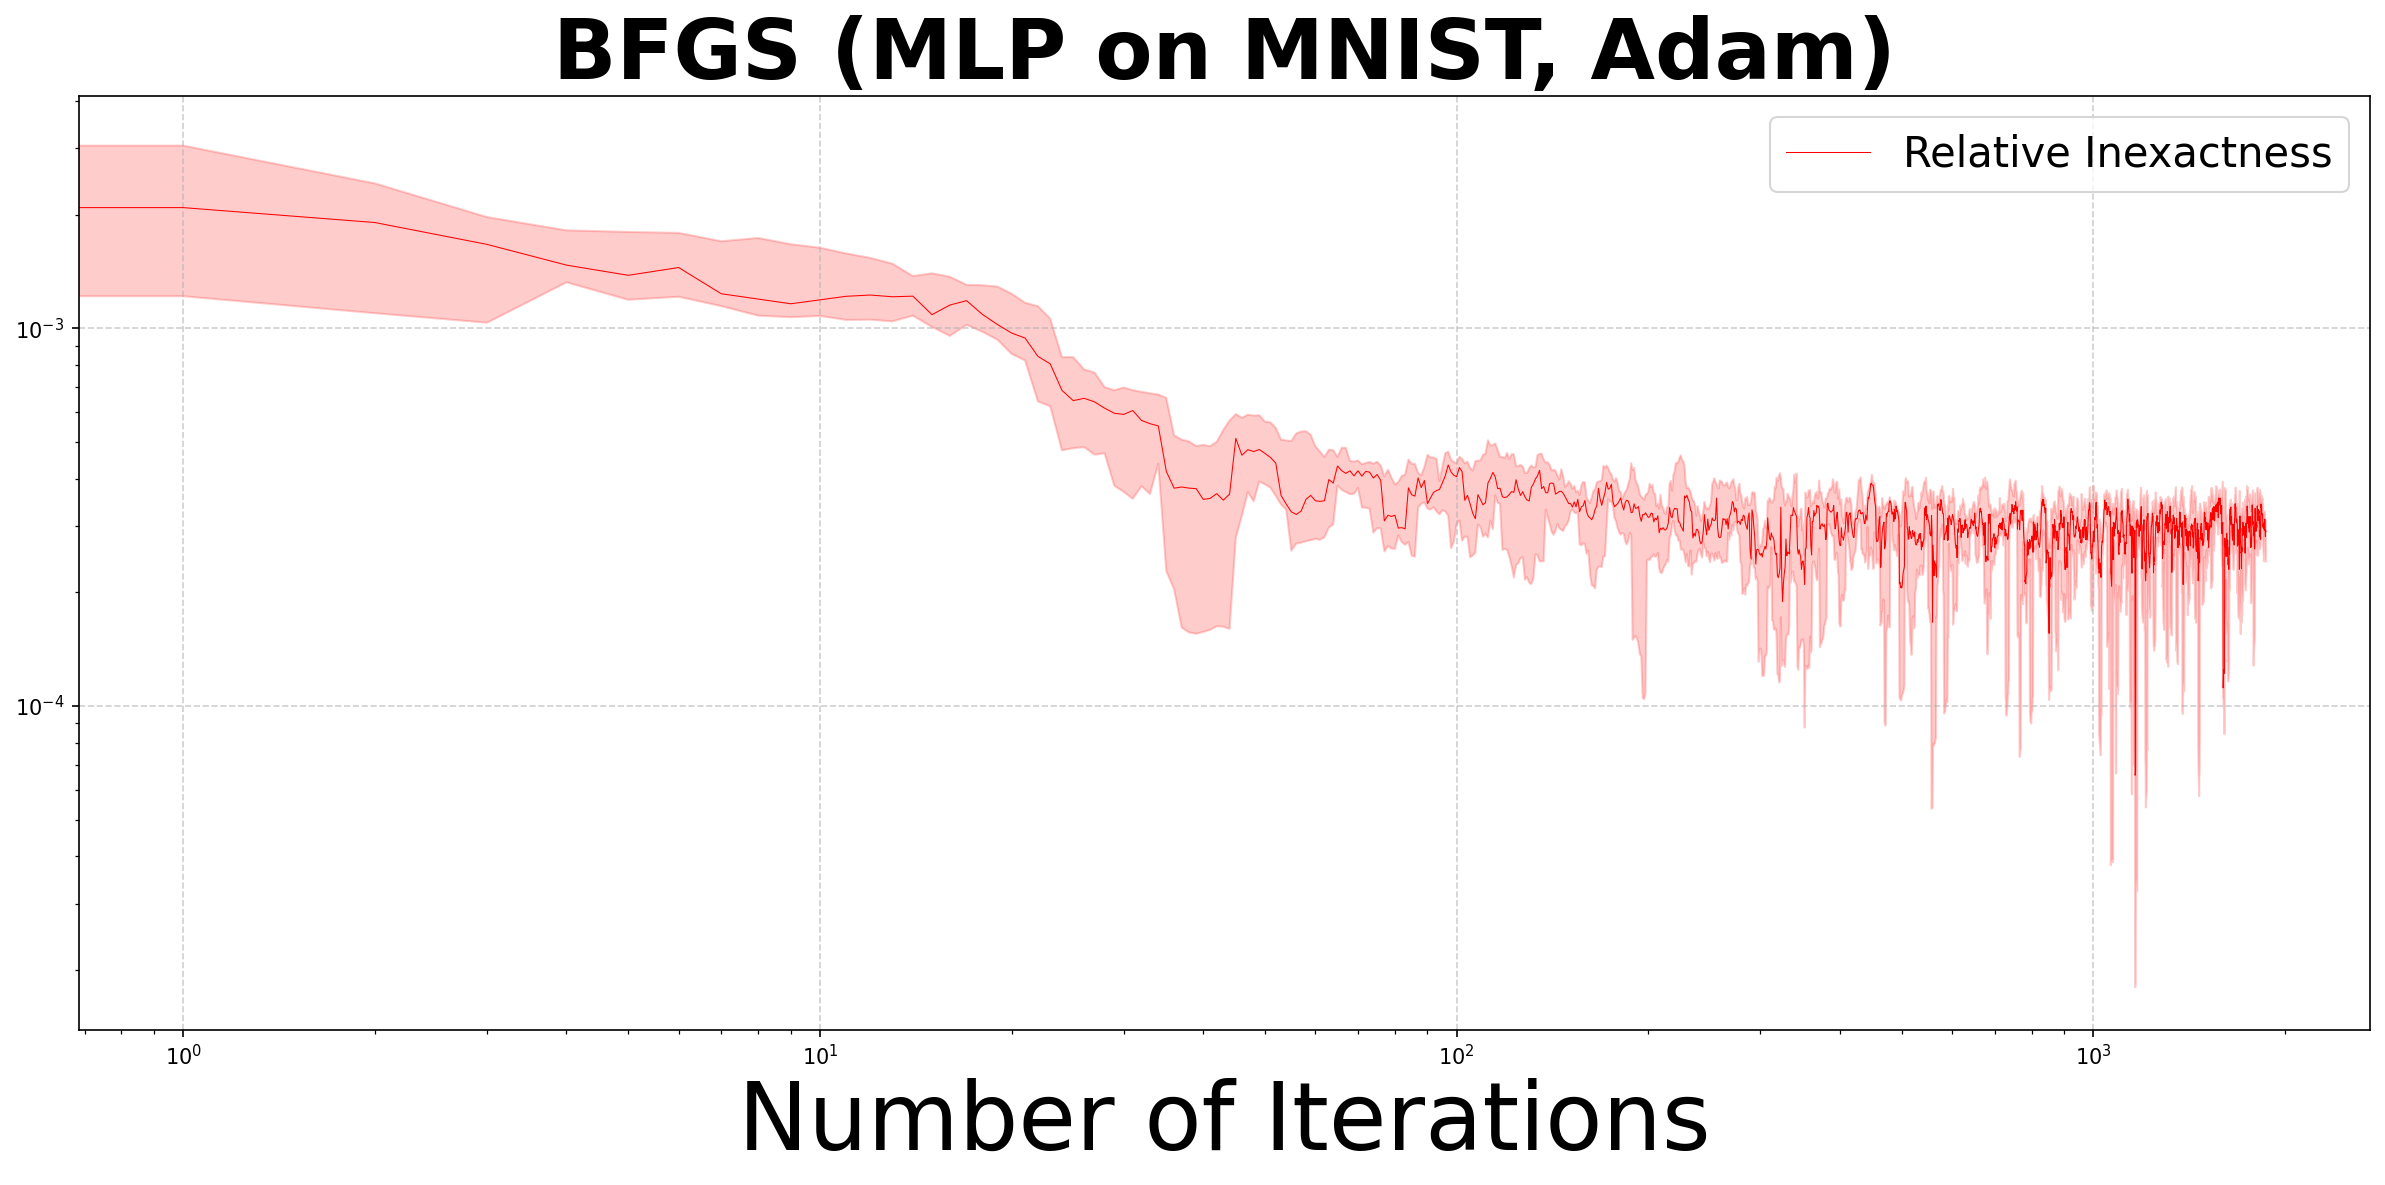

CPU times: user 2h 10min 16s, sys: 1min 16s, total: 2h 11min 32s
Wall time: 38min 36s


In [17]:
%%time
num_runs = 5
all_grad_norms_bfgs_mlp = []
all_hess_norms_bfgs_mlp = []
all_train_losses_bfgs_mlp = []
all_accuracy_arr_bfgs_mlp = []

for run in range(num_runs):
    print(f"Run {run+1}/{num_runs}")
    model = MLPModel().to(device)
    train_losses, grad_norms, hess_norms_diff, accuracy_arr = full_loop_mlp(model, train_loader, test_loader, device, num_epochs=2, lr=1e-3, norm_order=2)
    all_grad_norms_bfgs_mlp.append(grad_norms)
    all_hess_norms_bfgs_mlp.append(hess_norms_diff)
    all_train_losses_bfgs_mlp.append(train_losses)
    all_accuracy_arr_bfgs_mlp.append(accuracy_arr)

np.save('bfgs_mnist_grad_norms.npy', all_grad_norms_bfgs_mlp)
np.save('bfgs_mnist_hess_norms.npy', all_hess_norms_bfgs_mlp)

plot_relative_inexactness(
    'bfgs_mnist_grad_norms.npy',
    'bfgs_mnist_hess_norms.npy', 
    'BFGS (MLP on MNIST, Adam)',
    M_constant=1,
    plot_with_percentiles=True,
    logscale=True,
)